# What are the most optimal skills to learn for Data Analysts?

#### Methodology
1. Continue from last notebook to find percent of postings with skill
2. Visualize median salary vs percent skill demand
3. (Optional) Determine if certain technologies are more prevalent

#### Original Exploration
[15_Matplotlib_Scatter_Plots.ipynb](../2_Advanced/15_Matplotlib_Scatter_Plots.ipynb)

[16_Matplotlib_Advanced_Customization.ipynb](../2_Advanced/16_Matplotlib_Advanced_Customization.ipynb)

### Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

### Filtering the Data

In [3]:
# Setting what role and which country to explore
role = 'Data Analyst'
country = 'Hungary'

In [5]:
# Filtering for role and country, dropping rows without salary data
df_role_country = df[(df['job_title_short'] == role) & (df['job_country'] == country)].dropna(subset=['salary_year_avg']).copy()

# Getting each skill its own row
df_role_country_exploded = df_role_country.explode('job_skills')

# Display
df_role_country_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
11639,56700.0,sap
55707,80850.0,sap
61968,111202.0,sql
61968,111202.0,python
61968,111202.0,redshift


### Calculate Percentage of Job Postings that Have Skills

In [8]:
# Grouping by job_skills to get the count of skills and the median salary for each
df_role_skills = df_role_country_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_role_skills = df_role_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})
role_job_count = len(df_role_country)

# Calulating percentages of skill mention in postings
df_role_skills['skill_percent'] = df_role_skills['skill_count'] / role_job_count * 100

df_role_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,6,99500.0,33.333333
python,5,98500.0,27.777778
tableau,4,99500.0,22.222222
excel,4,85700.0,22.222222
sap,3,72900.0,16.666667
databricks,2,113950.0,11.111111
aws,2,113950.0,11.111111
git,2,81000.0,11.111111
sheets,2,75757.0,11.111111


### Median Salary vs Percent Skill Demand

In [9]:
# Filtering for skills that have a likelihood higher than our set limit
skill_percent = 10

df_role_skills_high_demand = df_role_skills[df_role_skills['skill_percent'] > skill_percent]

df_role_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,6,99500.0,33.333333
python,5,98500.0,27.777778
tableau,4,99500.0,22.222222
excel,4,85700.0,22.222222
sap,3,72900.0,16.666667
databricks,2,113950.0,11.111111
aws,2,113950.0,11.111111
git,2,81000.0,11.111111
sheets,2,75757.0,11.111111


Create a scatter plot to visualize the relationship between the percentage of our target role jobs that require specific skills and the median salary for those skills.

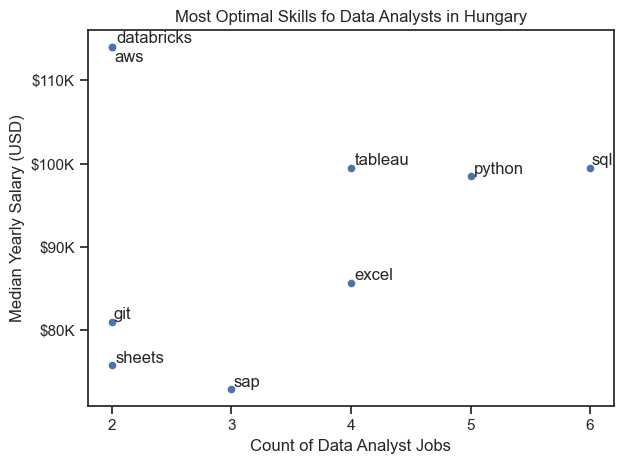

In [43]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

df_role_skills_high_demand.plot(kind='scatter', x='skill_count', y='median_salary')

# Putting texts on the plot
texts = []
positions = []

for i, txt in enumerate(df_role_skills_high_demand.index):
    x = df_role_skills_high_demand['skill_count'].iloc[i]
    y = df_role_skills_high_demand['median_salary'].iloc[i]
    positions.append([x, y, txt])

# Making sure ther is no overlap, if there is, offset
for position1 in positions:
    for position2 in positions:
        if position1 != position2:
            if (position1[0] == position2[0]) and (position1[1] == position2[1]):
                position2[1] -= 1500

for position in positions:
    x = position[0]
    y = position[1]
    txt = position[2]
    texts.append(plt.text(x, y, txt))

# Arrows to the dots from the texts in busy areas
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=1))

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.xlabel(f'Count of {role} Jobs')
plt.ylabel('Median Yearly Salary (USD)')
plt.title(f'Most Optimal Skills fo {role}s in {country}')
plt.tight_layout()

plt.show()

### Coloring by Technology

For this, we can utilize the `job_type_skills` column of our dataframe. We clean it up by removing the duplicates and missing values. Then we combine all the dictionaries in the column, we create a single dictionary, that we can turn into a dataframe to combine with our existing one. By doing this, we can specify the technology to which each skill belong and then color our scatter plot accordingly.

In [44]:
df_technology = df['job_type_skills'].copy()

# Removing duplicates
df_technology = df_technology.drop_duplicates()

# Remove NaN values
df_technology = df_technology.dropna()

# Combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row) # converts string into dictionary
    for key, value in row_dict.items():
        if key in technology_dict: # if the key already exists in technology_dict, add the value to the existing key
            technology_dict[key] += value
        else:                      # if the key does not exist in technology_dict, add the key and the value
            technology_dict[key] = value

# Removing duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [46]:
# Turn our dictionary into DataFrame
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,cognos
0,analyst_tools,powerpoint
0,analyst_tools,ssis
0,analyst_tools,datarobot
0,analyst_tools,esquisse
...,...,...
9,sync,twilio
9,sync,wire
9,sync,microsoft teams
9,sync,zoom


In [57]:
# Merging our DataFrames
df_plot = df_role_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skills')

df_plot

,skill_count,median_salary,skill_percent,technology,skills
0,6,99500.0,33.333333,programming,sql
1,5,98500.0,27.777778,programming,python
2,4,99500.0,22.222222,analyst_tools,tableau
3,4,85700.0,22.222222,analyst_tools,excel
4,3,72900.0,16.666667,analyst_tools,sap
5,2,113950.0,11.111111,cloud,databricks
6,2,113950.0,11.111111,cloud,aws
7,2,81000.0,11.111111,other,git
8,2,75757.0,11.111111,analyst_tools,sheets


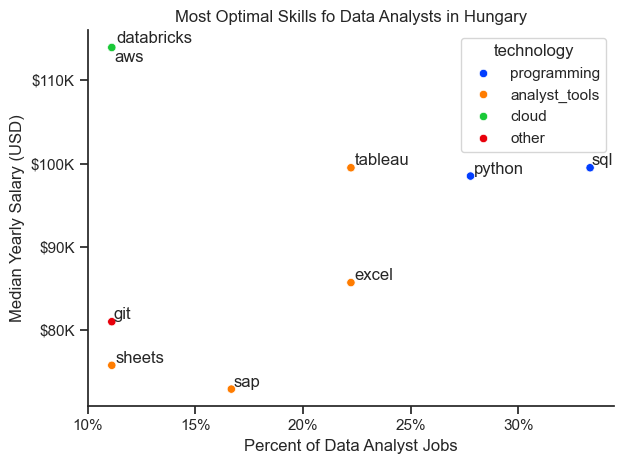

In [58]:
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter

sns.scatterplot(data=df_plot, x='skill_percent', y='median_salary', hue='technology', palette='bright', legend='full')
sns.set_theme(style='ticks')
sns.despine()

texts = []
positions = []

for i, txt in enumerate(df_role_skills_high_demand.index):
    x = df_role_skills_high_demand['skill_percent'].iloc[i]
    y = df_role_skills_high_demand['median_salary'].iloc[i]
    positions.append([x, y, txt])

for position1 in positions:
    for position2 in positions:
        if position1 != position2:
            if (position1[0] == position2[0]) and (position1[1] == position2[1]):
                position2[1] -= 1500

for position in positions:
    x = position[0]
    y = position[1]
    txt = position[2]
    texts.append(plt.text(x, y, txt))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=1))

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.xlabel(f'Percent of {role} Jobs')
plt.ylabel('Median Yearly Salary (USD)')
plt.title(f'Most Optimal Skills fo {role}s in {country}')
plt.tight_layout()

plt.show()